# Benefits of Contextualized ML

## Contextualized ML Enables High-Resolution Heterogeneity 
By sharing information between all contexts, contextualized learning is able to estimate heterogeneity at fine-grained resolution.
Cluster or cohort-based models treat every partition independently, limiting heterogeneity to
coarse-grained resolution where there are large enough cohorts for independent estimation.

### Problem Definition 
In this examples we are interested in learning Bayesian Networks (BNs) which are context-specific; i.e., the parameters and/or structure of the BNs may vary according to context. In this problem, for each observation $X∈R^p$, we also observe contextual data $C∈R^m$. We believe $X$ is generated by a network defined by $W$, which has parameters dependent on $C$. Based on the latter, we can describe this as factorizing $P(X, C) = \int_W{dW P(X|W)P(W|C)P(C)}$; where $P(X|W)=BN(X|W)$ is the distribution implied by the BN structure $W$.

In [169]:
# We need a few libraries
import numpy as np # for linear algebra operations
import pandas as pd # for data manipulation 
import networkx as nx # for drawing graphs
import matplotlib.pyplot as plt # for drawing graphs
import umap
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from IPython.utils import io # to manage the output of some functions 
from rich import print # style 
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

We then import the contextualized library, define $n$ simulated samples with context $C$. Gene expression $X$ depends on the BN defined by $W$, and is simulated using the helper function <i>simulate_linear_sem</i>, which simulates samples from linear structural equation modeling. 

In [147]:
#from contextualized import dev_dags
import sys
import contextualized

simulate_linear_sem = contextualized.dags.graph_utils.simulate_linear_sem 

# number of samples
n = 10000
# C is the context
C = np.random.choice([1,5,10], size=(n, 1))
scaler = MinMaxScaler()
C = scaler.fit_transform(C)
# W is the adjacency matrix that defines the BN
W = np.zeros((4, 4, n, 1)) # 4 genes and n adjacency matrices
W[0, 1] = C - 2
W[2, 1] = C**2
W[3, 1] = C**3
W[3, 2] = C
W = np.squeeze(W)
W = np.transpose(W, (2, 0, 1))
# X is the gene expression
X = np.zeros((n, 4))
for i, w in enumerate(W):
    x = simulate_linear_sem(w, 1, "uniform", noise_scale=0.1)[0]
    X[i] = x

In [148]:
%%capture
from contextualized.easy import ContextualizedBayesianNetworks
with io.capture_output() as captured:
    cbn = ContextualizedBayesianNetworks(
        encoder_type='mlp', num_archetypes=16,
        n_bootstraps=2, archetype_dag_loss_type="DAGMA", archetype_alpha=0.,
        sample_specific_dag_loss_type="DAGMA", sample_specific_alpha=1e-1,
        learning_rate=1e-3)
cbn.fit(C, X, max_epochs=10)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type      | Params
----------------------------------------
0 | encoder   | MLP       | 1.8 K 
1 | explainer | Explainer | 256   
----------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type      | Params
----------------------------------------
0 | encoder   | MLP       | 1.8 K 
1 | explainer | Explainer | 256   
----------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Now, if we consider a constant $C$, we are indirectly defining a population model. We use this idea to compare the performance of contextualized against not-contextualized BNs.

In [149]:
%%capture
const_C = np.ones((n, 1))
const_C = scaler.transform(const_C)
bn = ContextualizedBayesianNetworks(
    encoder_type='mlp', num_archetypes=16,
    n_bootstraps=2, archetype_dag_loss_type="DAGMA", archetype_alpha=0.,
    sample_specific_dag_loss_type="DAGMA", sample_specific_alpha=1e-1,
    learning_rate=1e-3)
bn.fit(const_C, X, max_epochs=10)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type      | Params
----------------------------------------
0 | encoder   | MLP       | 1.8 K 
1 | explainer | Explainer | 256   
----------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type      | Params
----------------------------------------
0 | encoder   | MLP       | 1.8 K 
1 | explainer | Explainer | 256   
----------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


In [151]:
error_context = np.mean(((cbn.predict_networks(C) - W) ** 2) / n)
error_uncontext = np.mean(((bn.predict_networks(C) - W) ** 2) / n)
print(f'[bold green]Contextualized Model\'s Mean Squared Error = [bold cyan]{error_context:.2}')
print(f'[bold green]Not-Contextualized Model\'s Mean Squared Error = [bold cyan]{error_uncontext:.2}')

Contextualized Model's Mean Squared Error = 3.2e-06

Not-Contextualized Model's Mean Squared Error = 7.3e-06

 Comparison of inferred BNs

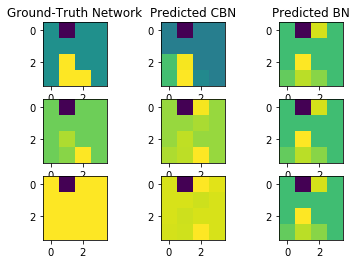

In [152]:
# Predict and visualize network
predicted_contextualized_networks = cbn.predict_networks(C)
predicted_networks = bn.predict_networks(C)
print(f'[bold green] Comparison of inferred BNs')

f, axarr = plt.subplots(3, 3)

index_of_1 = np.where(C == 1)[0][0]
index_of_2 = np.where(np.isclose(C, 0.4, atol = 0.099))[0][0]
index_of_3 = np.where(C == 0)[0][0]

axarr[0,0].imshow(W[index_of_1])
axarr[0,1].imshow(predicted_contextualized_networks[index_of_1])
axarr[0,2].imshow(predicted_networks[index_of_1])
axarr[1,0].imshow(W[index_of_2])
axarr[1,1].imshow(predicted_contextualized_networks[index_of_2])
axarr[1,2].imshow(predicted_networks[index_of_2])
axarr[2,0].imshow(W[index_of_3])
axarr[2,1].imshow(predicted_contextualized_networks[index_of_3])
axarr[2,2].imshow(predicted_networks[index_of_3])


axarr[0,0].set_title("Ground-Truth Network")
axarr[0,1].set_title("Predicted CBN")
axarr[0,2].set_title("Predicted BN")

plt.show()

## Contextualized ML Enables Analysis of Latent Processes
Cluster or cohort models are inferred by partitioning data into groups, assumed to be iid, and estimating models for each groups. This
is only likely to be satisfied when contexts are discrete, low-dimensional, and every context-specific
population is well observed. In real life, contexts are often continuous, high dimensional, and sparsely
observed. When cluster or cohort approaches are applied in these circumstances, downstream modeling tasks are distorted by mis-specification, where many non-id samples are funneled into a single model. Consequently, there are no theoretical guarantees in many real life circumstances about how
well a cluster or cohort model can represent heterogeneous populations. Alternatively, contextualized
learning provides a way to estimate latent, non-id models for all samples with minimal assumptions
about the grouping or clustering of these samples, or the functional relationship between latent models and contexts. Samples can then be grouped on the basis of model parameters and distributional
differences to produce clusters in the latent model space underlying each sample. Contextualized ML
intuitively recovers latent structures underlying data generation in a way a priori clustering cannot. Allowing downstream models to determine the grouping of samples rather than upstream contexts replaces
traditional cluster analysis with contextualized analysis clusters.

Following the example depicted above, let's suppose the there is a variable $Z$ that we cannot observe and depends on the covariates $C$. This variable will affect the structure $W$ and therefore $X$. In our example, we suppose that $Z$ is modeled by $Z = \beta(C) + \epsilon$. We, therefore, consider a latent variable $Z \in \R^{K}$ such that $C \bot (X, W) | Z$. <br> 
The relative probabilistic model is then $P(W|X, C) \propto P(W|X) \int_Z dZ P(W|Z) P(Z|C) $; where $P(X|W) = BN(X|W)$.  
<div style="text-align:center"> <img src="vis_mod.png" /> </div> 

In [158]:
# number of samples
n = 10000
# Covariates C
C = np.random.normal(-1, 1, (n, 3))
# beta
beta = np.random.normal(-1, 1, (3, 1))
# Latent Variable Z
Z = np.matmul(C, beta)

# W is the adjacency matrix that defines the BN
W = np.zeros((4, 4, n, 1)) # 4 genes and n adjacency matrices
W[0, 1] = Z - 2
W[2, 1] = Z**2
W[3, 1] = Z**3
W[3, 2] = Z
W = np.squeeze(W)
W = np.transpose(W, (2, 0, 1))
# X is the gene expression
X = np.zeros((n, 4))
for i, w in enumerate(W):
    x = simulate_linear_sem(w, 1, "uniform", noise_scale=0.1)[0]
    X[i] = x

In [164]:
%%capture
cbn = ContextualizedBayesianNetworks(
    encoder_type='mlp', num_archetypes=16,
    n_bootstraps=2, archetype_dag_loss_type="DAGMA", archetype_alpha=0.,
    sample_specific_dag_loss_type="DAGMA", sample_specific_alpha=1e-1,
    learning_rate=1e-3)
cbn.fit(C, X, max_epochs=10)
const_C = np.ones((n, 3))
bn = ContextualizedBayesianNetworks(
    encoder_type='mlp', num_archetypes=16,
    n_bootstraps=2, archetype_dag_loss_type="DAGMA", archetype_alpha=0.,
    sample_specific_dag_loss_type="DAGMA", sample_specific_alpha=1e-1,
    learning_rate=1e-3)
bn.fit(const_C, X, max_epochs=10)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type      | Params
----------------------------------------
0 | encoder   | MLP       | 1.8 K 
1 | explainer | Explainer | 256   
----------------------------------------
2.1 K     Trainable params
0         Non-trainable params
2.1 K     Total params
0.008     Total estimated model params size (MB)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type      | Params
----------------------------------------
0 | encoder   | MLP       | 1.8 K 
1 | explainer | Explainer | 256   
----------------------------------------
2.1 K     Trainable params
0         Non-trainable params
2.1 K     Total params
0.008     Total estimated model params size (MB)
GPU available: False, used: False
TPU available: False, using: 0 TPU c

In [166]:
error_context = np.mean(((cbn.predict_networks(C) - W) ** 2) / n)
error_uncontext = np.mean(((bn.predict_networks(C) - W) ** 2) / n)
print(f'[bold green]Contextualized Model\'s Mean Squared Error = [bold cyan]{error_context:.2}')
print(f'[bold green]Not-Contextualized Model\'s Mean Squared Error = [bold cyan]{error_uncontext:.2}')

Contextualized Model's Mean Squared Error = 0.0008

Not-Contextualized Model's Mean Squared Error = 0.002

 Comparison of inferred BNs

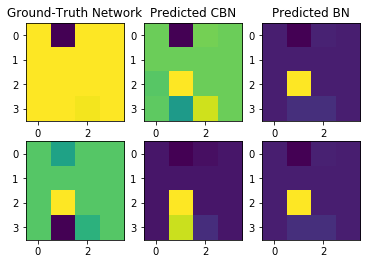

In [167]:
# Predict and visualize network
predicted_contextualized_networks = cbn.predict_networks(C)
predicted_networks = bn.predict_networks(C)
print(f'[bold green] Comparison of inferred BNs')

f, axarr = plt.subplots(2, 3)

index_of_1 = np.where(C == np.min(C))[0][0]
index_of_2 = np.where(C == np.max(C))[0][0]

axarr[0,0].imshow(W[index_of_1])
axarr[0,1].imshow(predicted_contextualized_networks[index_of_1])
axarr[0,2].imshow(predicted_networks[index_of_1])
axarr[1,0].imshow(W[index_of_2])
axarr[1,1].imshow(predicted_contextualized_networks[index_of_2])
axarr[1,2].imshow(predicted_networks[index_of_2])

axarr[0,0].set_title("Ground-Truth Network")
axarr[0,1].set_title("Predicted CBN")
axarr[0,2].set_title("Predicted BN")

plt.show()

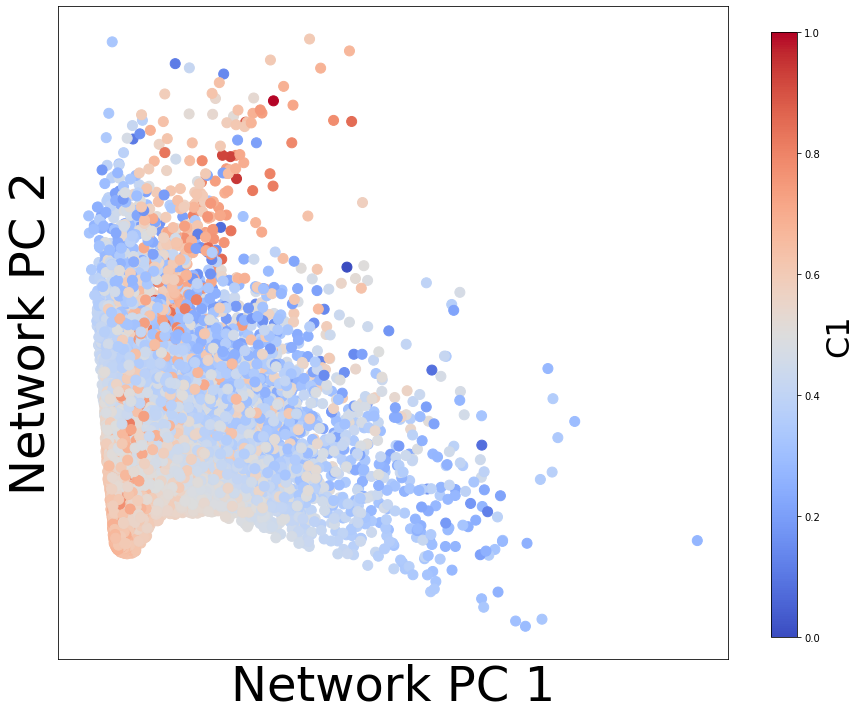

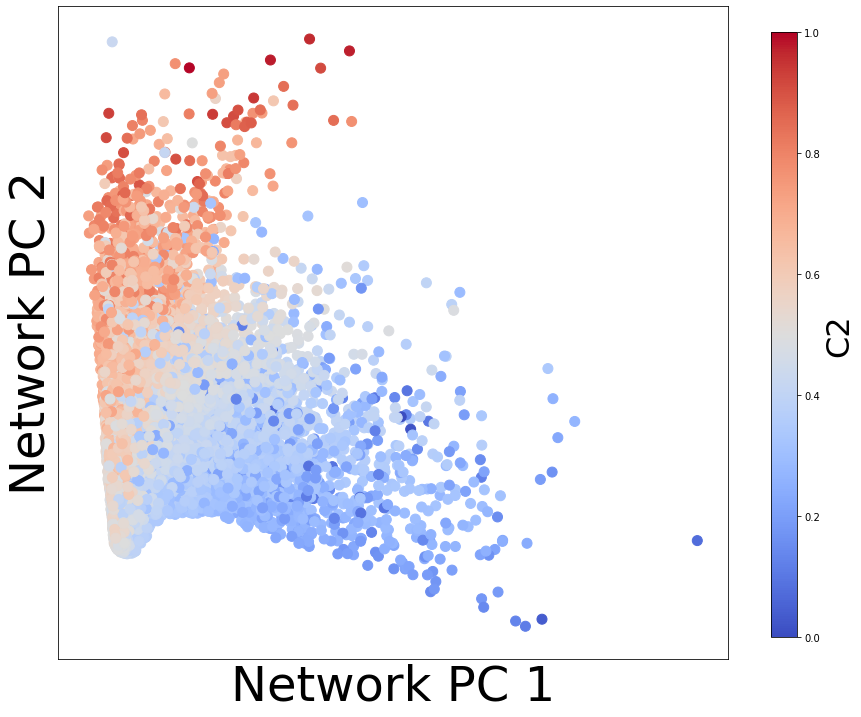

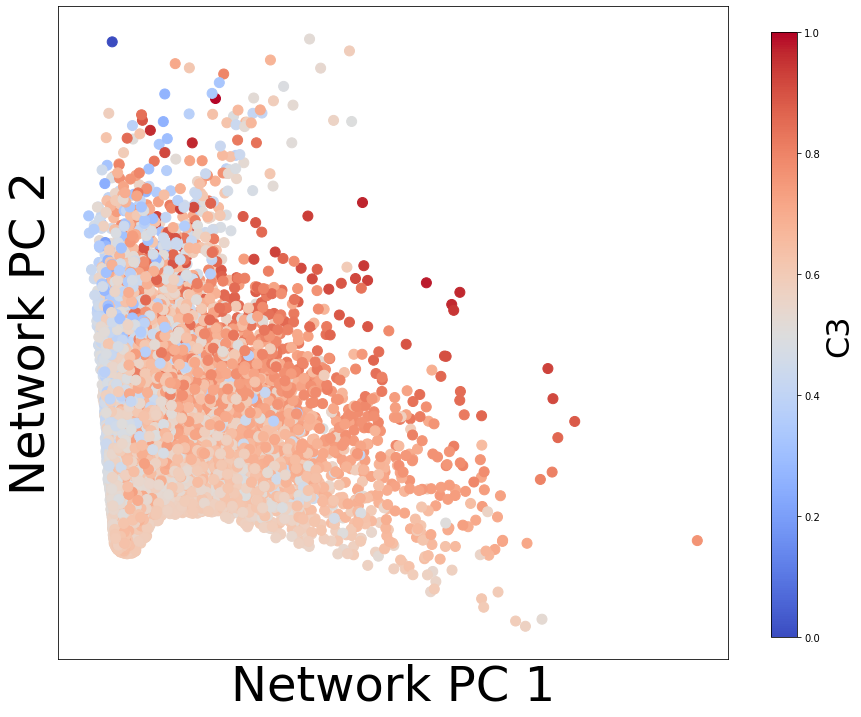

In [199]:
# We can embed networks in lower-dimensional spaces to visualize distributions.
from contextualized.analysis.embeddings import plot_embedding_for_all_covars

#low_dim_networks = umap.UMAP().fit_transform(predicted_contextualized_networks.reshape((n, -1)))
low_dim_networks = PCA(n_components=2).fit_transform(predicted_contextualized_networks.reshape((n, -1)))
plot_embedding_for_all_covars(low_dim_networks[:, :2], pd.DataFrame(C, columns=['C1', 'C2', 'C3']),
                             xlabel="Network PC 1", ylabel="Network PC 2")

$Z$ is a latent variable that depends on $C$, and also defines the structures of the networks $W$. We visualize how $Z$ is distributed in the embedded space of $C$, and how $W$ changes accordingly.

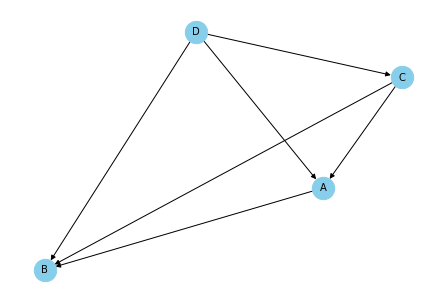

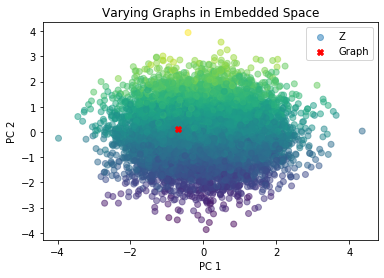

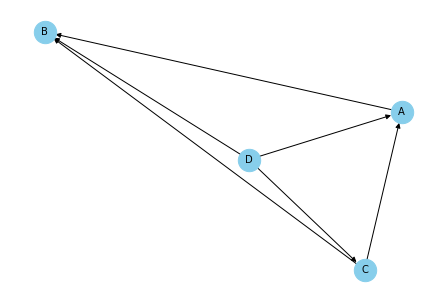

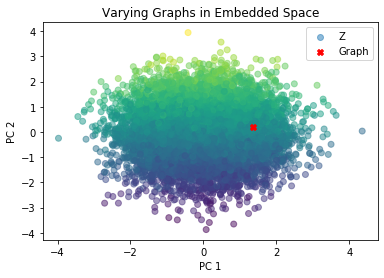

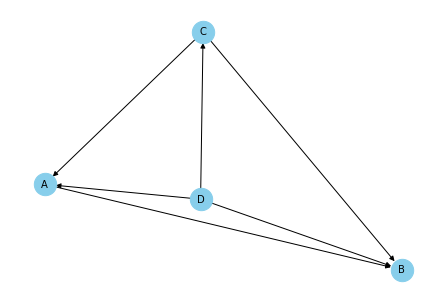

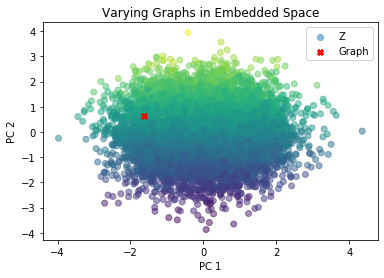

In [195]:
pca = PCA(n_components=2)  
embedded_space = pca.fit_transform(C)

# Sample 3 random graphs
random_graphs_idxs = np.random.choice(range(n), size=3)
random_graphs = predicted_contextualized_networks[random_graphs_idxs]

for idx, random_graph in enumerate(random_graphs):
    # Apply the same dimensionality reduction to the graph-specific covariates
    embedded_graph = pca.transform([C[random_graphs_idxs[idx]]])
    
    # Define graph and add nodes
    G = nx.DiGraph()
    nodes = ['A', 'B', 'C', 'D']
    for node_label in nodes: G.add_node(node_label)
    
    for i in range(W.shape[1]):
        for j in range(W.shape[2]):
            if random_graph[i][j] != 0:
                G.add_edge(nodes[i], nodes[j])

    # Set the layout for the graph (e.g., hierarchical layout)
    pos = nx.spring_layout(G)

    # Plot the graph
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_color='black', arrowsize=10)

    # Show the plot
    plt.show()

    # Plot the graph in the embedded space
    plt.scatter(
        data=pd.DataFrame({'PC1': embedded_space[:, 0], 'PC2': embedded_space[:, 1], 'Z': Z.ravel()}),
        x = 'PC1', y = 'PC2', c='Z', alpha=0.5, label = 'Z')  # Plot the embedded space
    plt.scatter(embedded_graph[:, 0], embedded_graph[:, 1], c='red', marker='X', label='Graph')  # Plot the graph

    # Add labels, legends, and other plot customizations as needed
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.legend()
    plt.title('Varying Graphs in Embedded Space')

    # Show or save the plot
    plt.show()

## Contextualized ML Interpolates Between Observed Contexts 
By learning to translate contextual information into model parameters, contextualized models learn about the meta-distribution of
contexts. As a result, contextualized models can adapt to contexts which were never observed
in the training data by interpolating between observed contexts or extrapolating to new contexts.

Le's assume we observe a certain set of contexts in our initial population, how well does the contextualized model generalize to new/unobserved contexts?

In [200]:
# number of samples
n = 10000
# C is the context
# C in [1,2] & [5,6] for the initial population
# C in [2,5] for the unobserved population
fraction = n//8
# Generate values for each subgroup using normal distributions
subgroup1 = np.random.normal(loc=1.5, scale=0.2, size=2 * fraction)  # Mean=1.5, Std=0.2
subgroup2 = np.random.normal(loc=5.5, scale=0.5, size=4 * fraction)  # Mean=5.5, Std=0.5
subgroup3 = np.random.normal(loc=3.5, scale=0.7, size=2 * fraction)  # Mean=3.5, Std=0.7

# Concatenate the subgroups to create the vector C
C = np.concatenate([subgroup1, subgroup2, subgroup3]).reshape((n, 1))
scaler = MinMaxScaler()
C = scaler.fit_transform(C)

# W is the adjacency matrix that defines the BN
W = np.zeros((4, 4, n, 1)) # 4 genes and n adjacency matrices
W[0, 1] = C - 2
W[2, 1] = C**2
W[3, 1] = C**3
W[3, 2] = C
W = np.squeeze(W)
W = np.transpose(W, (2, 0, 1))
# X is the gene expression
X = np.zeros((n, 4))
for i, w in enumerate(W):
    x = simulate_linear_sem(w, 1, "uniform", noise_scale=0.1)[0]
    X[i] = x

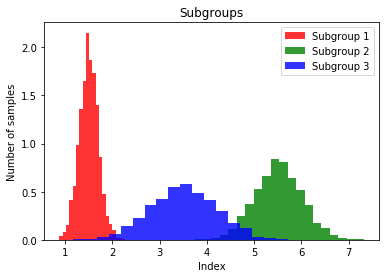

In [234]:
plt.hist(subgroup1, bins=20, alpha=0.8, color='r', label='Subgroup 1', density=True)
plt.hist(subgroup2, bins=20, alpha=0.8, color='g', label='Subgroup 2', density=True)
plt.hist(subgroup3, bins=20, alpha=0.8, color='b', label='Subgroup 3', density=True)

plt.xlabel('Index')
plt.ylabel('Number of samples')
plt.title('Subgroups')
plt.legend()
plt.show()

In [202]:
%%capture
cbn = ContextualizedBayesianNetworks(
    encoder_type='mlp', num_archetypes=16,
    n_bootstraps=2, archetype_dag_loss_type="DAGMA", archetype_alpha=0.,
    sample_specific_dag_loss_type="DAGMA", sample_specific_alpha=1e-1,
    learning_rate=1e-3)
cbn.fit(C[:6 * fraction], X[:6 * fraction], max_epochs=10)
const_C = np.ones((6 * fraction, 1))
const_C = scaler.transform(const_C)
bn = ContextualizedBayesianNetworks(
    encoder_type='mlp', num_archetypes=16,
    n_bootstraps=2, archetype_dag_loss_type="DAGMA", archetype_alpha=0.,
    sample_specific_dag_loss_type="DAGMA", sample_specific_alpha=1e-1,
    learning_rate=1e-3)
bn.fit(const_C, X[:6 * fraction], max_epochs=10)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type      | Params
----------------------------------------
0 | encoder   | MLP       | 1.8 K 
1 | explainer | Explainer | 256   
----------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type      | Params
----------------------------------------
0 | encoder   | MLP       | 1.8 K 
1 | explainer | Explainer | 256   
----------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)
GPU available: False, used: False
TPU available: False, using: 0 TPU c

In [204]:
error_context = np.mean(((cbn.predict_networks(C) - W) ** 2) / n)
error_uncontext = np.mean(((bn.predict_networks(C) - W) ** 2) / n)
print(f'[bold green]Contextualized Model\'s Mean Squared Error = [bold cyan]{error_context:.2}')
print(f'[bold green]Not-Contextualized Model\'s Mean Squared Error = [bold cyan]{error_uncontext:.2}')

Contextualized Model's Mean Squared Error = 1.5e-06

Not-Contextualized Model's Mean Squared Error = 3.3e-06

 Comparison of inferred BNs

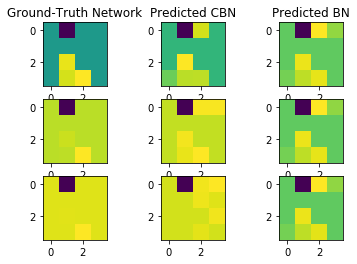

In [229]:
# Predict and visualize network
predicted_contextualized_networks = cbn.predict_networks(C)
predicted_networks = bn.predict_networks(C)
print(f'[bold green] Comparison of inferred BNs')

f, axarr = plt.subplots(3, 3)

index_of_1 = np.where(np.isclose(C, 1, atol = 0.099))[0][0]
index_of_2 = np.where(np.isclose(C, 0.3, atol = 0.099))[0][0]
index_of_3 = np.where(np.isclose(C, 0, atol = 0.099))[0][0]

axarr[0,0].imshow(W[index_of_1])
axarr[0,1].imshow(predicted_contextualized_networks[index_of_1])
axarr[0,2].imshow(predicted_networks[index_of_1])
axarr[1,0].imshow(W[index_of_2])
axarr[1,1].imshow(predicted_contextualized_networks[index_of_2])
axarr[1,2].imshow(predicted_networks[index_of_2])
axarr[2,0].imshow(W[index_of_3])
axarr[2,1].imshow(predicted_contextualized_networks[index_of_3])
axarr[2,2].imshow(predicted_networks[index_of_3])


axarr[0,0].set_title("Ground-Truth Network")
axarr[0,1].set_title("Predicted CBN")
axarr[0,2].set_title("Predicted BN")

plt.show()

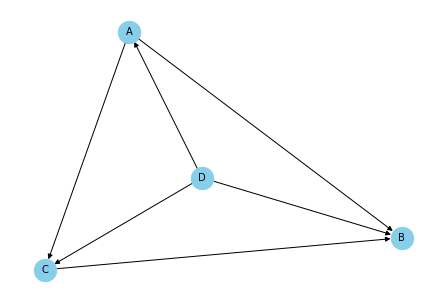

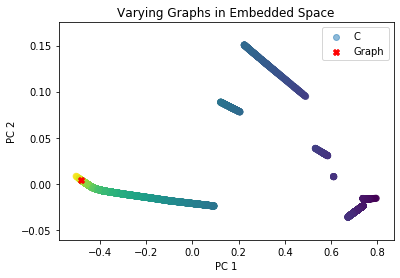

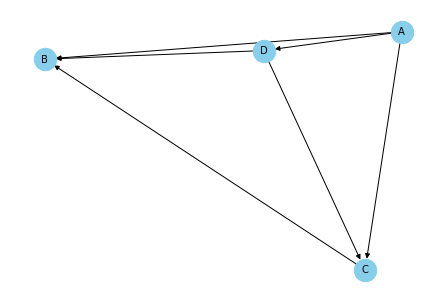

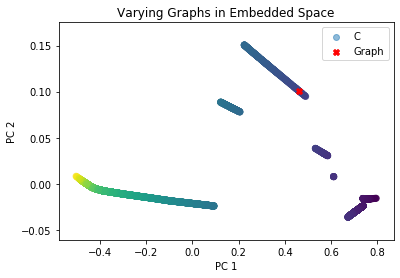

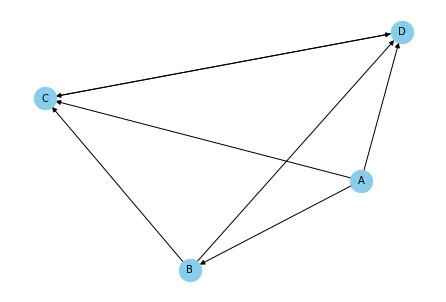

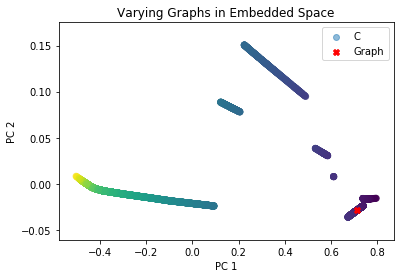

In [230]:
# Create a PCA object and fit it to your covariate data
pca = PCA(n_components=2)  # Choose the number of components you want
embedded_space = pca.fit_transform(predicted_contextualized_networks.reshape((n, -1)))

# Sample 3 random graphs
graphs_idxs = [index_of_1, index_of_2, index_of_3]
graphs = predicted_contextualized_networks[graphs_idxs]

for idx, graph in enumerate(graphs):
    # Apply the same dimensionality reduction to the graph-specific covariates
    embedded_graph = pca.transform([predicted_contextualized_networks.reshape((n, -1))[graphs_idxs[idx]]])
    
    # Define graph and add nodes
    G = nx.DiGraph()
    nodes = ['A', 'B', 'C', 'D']
    for node_label in nodes: G.add_node(node_label)
    
    for i in range(W.shape[1]):
        for j in range(W.shape[2]):
            if graph[i][j] != 0:
                G.add_edge(nodes[i], nodes[j])

    # Set the layout for the graph (e.g., hierarchical layout)
    pos = nx.spring_layout(G)

    # Plot the graph
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_color='black', arrowsize=10)

    # Show the plot
    plt.show()

    # Plot the graph in the embedded space
    plt.scatter(
        data=pd.DataFrame({'PC1': embedded_space[:, 0], 'PC2': embedded_space[:, 1], 'C': C.ravel()}),
        x = 'PC1', y = 'PC2', c='C', alpha=0.5, label = 'C')  # Plot the embedded space
    plt.scatter(embedded_graph[:, 0], embedded_graph[:, 1], c='red', marker='X', label='Graph')  # Plot the graph

    # Add labels, legends, and other plot customizations as needed
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.legend()
    plt.title('Varying Graphs in Embedded Space')

    # Show or save the plot
    plt.show()

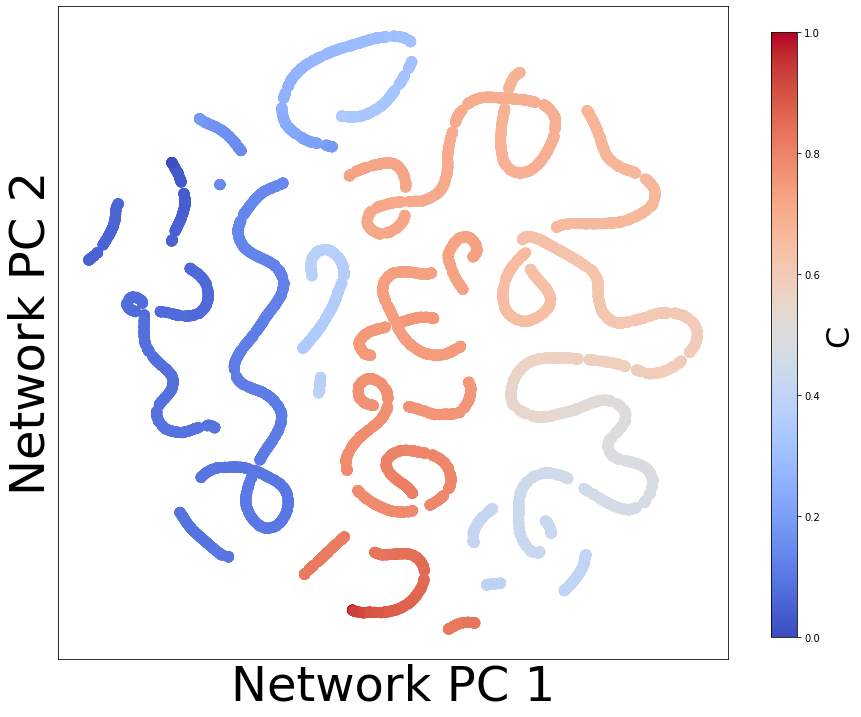

In [235]:
#low_dim_networks = PCA(n_components=2).fit_transform(predicted_contextualized_networks.reshape((n, -1)))
low_dim_networks = umap.UMAP().fit_transform(predicted_contextualized_networks.reshape((n, -1)))
plot_embedding_for_all_covars(low_dim_networks[:, :2], pd.DataFrame(C, columns=['C']),
                             xlabel="Network PC 1", ylabel="Network PC 2")

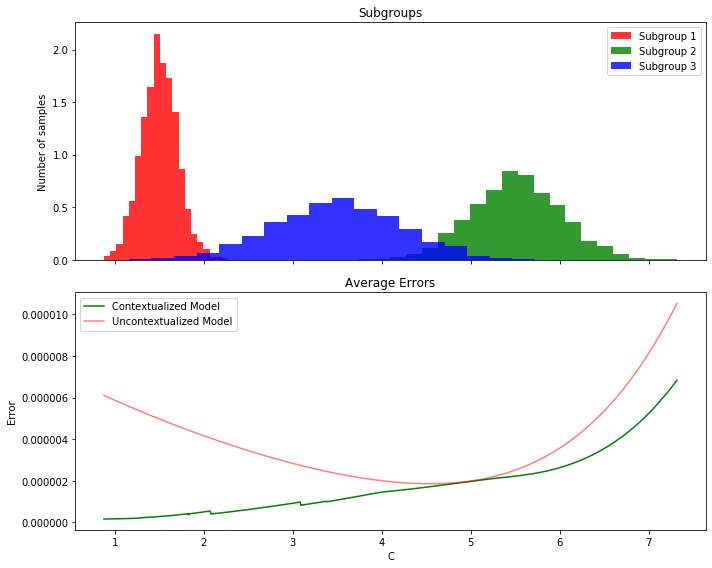

In [232]:
# Create subplots for the data and errors
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot histograms for each subgroup
# Plot histograms for each subgroup
ax1.hist(subgroup1, bins=20, alpha=0.8, color='r', label='Subgroup 1', density=True)
ax1.hist(subgroup2, bins=20, alpha=0.8, color='g', label='Subgroup 2', density=True)
ax1.hist(subgroup3, bins=20, alpha=0.8, color='b', label='Subgroup 3', density=True)


# Configure the first subplot
ax1.set_ylabel('Number of samples')
ax1.set_title('Subgroups')
ax1.legend()

error_context = ((cbn.predict_networks(C) - W) ** 2) / n
error_uncontext = ((bn.predict_networks(C) - W) ** 2) / n

# Calculate the average error per value of C
unique_values_of_C = np.unique(C)
average_errors_context, average_errors_uncontext = [], []

for value_of_C in unique_values_of_C:
    mask = (C.ravel() == value_of_C)
    average_error_context = np.mean(error_context[mask])
    average_error_uncontext = np.mean(error_uncontext[mask])
    average_errors_context.append(average_error_context)
    average_errors_uncontext.append(average_error_uncontext)

# Create a scatter plot to show the average errors
ax2.plot(scaler.inverse_transform(unique_values_of_C.reshape(-1, 1)).ravel(), average_errors_context, c='g', alpha = 1, linestyle='-', label='Contextualized Model')
ax2.plot(scaler.inverse_transform(unique_values_of_C.reshape(-1, 1)).ravel(), average_errors_uncontext, c='r', alpha = 0.5, linestyle='-', label='Uncontextualized Model')
# Plot the error lines in the second subplot

# Configure the second subplot
ax2.set_xlabel('C')
ax2.set_ylabel('Error')
ax2.set_title('Average Errors')
ax2.legend()

plt.tight_layout()
plt.show()